# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Dev Scalars Log Link</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
%load_ext tensorboard
#%reload_ext tensorboard

%tensorboard --logdir=logs_kenyan_food_resnext

In [ ]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


from torchvision import datasets, transforms, models

from torch.optim import lr_scheduler

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import pandas as pd

from PIL import Image

from tqdm import tqdm

## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods that will be used to get training and validation data loader.

For example,

```
def get_data(args1, *agrs):
    ....
    ....
    return train_loader, test_loader
```

In [ ]:
class Food13Dataset(Dataset):
    def __init__(self, data, transform=None):
        super().__init__()

        self.transform = transform

        # initialize the arrays to store the ground truth labels and paths to the images
        self.data_path = []
        self.labels = []

        # iterate over the data numpy array
        for i , (img_path,cls) in enumerate (data):
            self.data_path.append(img_path)
            self.labels.append(class_to_id[cls])


    def __len__(self):
        return len(self.data_path)

    def __getitem__(self, idx):
        # take the data sample by its index
        img_path = self.data_path[idx]

        # read image
        img = Image.open(img_path)

        # apply the image augmentations if needed
        if self.transform:
            img = self.transform(img)

        # return the image and its associated labels and path
        target = self.labels[idx]

        return img, target

    def image_path(self, idx):
        return self.data_path[idx]

    def class_name(self, label):
        return id_to_class[label]

In [ ]:
def image_preprocess_transforms():

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])

    return preprocess

In [ ]:
def image_common_transforms(mean=(0.5773, 0.4627, 0.3468), std=(0.2387, 0.2470, 0.2473)):
    preprocess = image_preprocess_transforms()

    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])

    return common_transforms

In [ ]:
def data_loader(data, transform, batch_size=32, shuffle=False, num_workers=2):

    dataset =  Food13Dataset(data, transform = transform)

    loader = DataLoader(dataset,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=shuffle)

    return loader

In [ ]:
def get_data(train_data, val_data, batch_size, num_workers=4, data_augmentation=False):


    mean=(0.5773, 0.4627, 0.3468)
    std=(0.2387, 0.2470, 0.2473)

    common_transforms = image_common_transforms()


    # if data_augmentation is true
    # data augmentation implementation
    if data_augmentation:
        train_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ColorJitter(brightness = 0.6),
            transforms.RandomChoice([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(20, fill=(0,0,0)),
                transforms.RandomCrop(224, padding=4),
                transforms.RandomAffine(30, translate=(0.3,0.3),
                                        scale=(0.8, 1.2), shear=None)
            ]),

            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    # else do common transforms
    else:
        train_transforms = common_transforms


    # train dataloader

    train_loader = data_loader(train_data,
                               train_transforms,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers=num_workers)

    # test dataloader


    test_loader = data_loader(val_data,
                              common_transforms,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=num_workers)

    return train_loader, test_loader

## <font style="color:green">2. Configuration [5 Points]</font>

Define your configuration in this section.

For example,

```
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10
    epochs_count: int = 50
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5
    test_interval: int = 1
    data_root: str = "./cat-dog-panda"
    num_workers: int = 2
    device: str = 'cuda'

```

In [ ]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [ ]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32
    epochs_count: int = 60
    init_learning_rate: float = 0.0001  # initial learning rate for lr scheduler
    log_interval: int = 10
    test_interval: int = 1
    num_workers: int = 8
    device: str = 'cuda'

In [ ]:
#System Setup

def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

Define methods or classes that will be used in model evaluation, for example, accuracy, f1-score, etc.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
def prediction(model, device, batch_input):

    # send model to cpu/cuda according to your system configuration
    model.to(device)

    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]

    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]

    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

In [ ]:
def get_prediction(model, data, mean, std):

    batch_size = 60

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2



    # transformed data
    val_dataset_trans = Food13Dataset(data, transform=image_common_transforms())


    data_len = val_dataset_trans.__len__()
    total_batches = data_len//batch_size
    rem_batch = data_len % batch_size

    targets = []
    classes = []

    count = 0
    # We prefer to do the predictions in batches and combine them later
    for j in range(total_batches):

        inputs = []
        print("Getting predictions for batch ",j+1,"...")
        for i in range(batch_size):
            index = count
            trans_input, target = val_dataset_trans.__getitem__(index)


            inputs.append(trans_input)
            targets.append(target)
            count+= 1

        inputs = torch.stack(inputs)



        cls, prob = prediction(model, device, batch_input=inputs)
        classes.extend([item for item in cls])


    # Calculate predictions for the last remaining batch
    inputs = []
    print("Getting predictions for the last batch...")
    for i in range(rem_batch):
        index = count
        trans_input, target = val_dataset_trans.__getitem__(index)


        inputs.append(trans_input)
        targets.append(target)
        count+= 1

    inputs = torch.stack(inputs)

    cls, prob = prediction(model, device, batch_input=inputs)
    classes.extend([item for item in cls])

    return np.array(classes), np.array(targets)

In [ ]:
def accuracy_and_confusion_matrix(target, cls, id_to_class):

    accuracy = accuracy_score(target, cls)
    cn_matrix = confusion_matrix(target,cls, labels = list(id_to_class.keys()))

    return accuracy, cn_matrix

## <font style="color:green">4. Train and Validation [5 Points]</font>

Write the methods or classes that will be used for training and validation.

In [ ]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int, tb_writer: SummaryWriter
) -> None:

    # change model in training mood
    model.train()

    # to get batch loss
    batch_loss = np.array([])

    # to get batch accuracy
    batch_acc = np.array([])

    for batch_idx, (data, target) in enumerate(train_loader):

        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()

        # forward pass to the model
        output = model(data)

        # cross entropy loss
        loss = F.cross_entropy(output, target)

        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()

        batch_loss = np.append(batch_loss, [loss.item()])

        # Score to probability using softmax
        prob = F.softmax(output, dim=1)

        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]

        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()

        # accuracy
        acc = float(correct) / float(len(data))

        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:

            total_batch = epoch_idx * len(train_loader.dataset)/train_config.batch_size + batch_idx
            tb_writer.add_scalar('Loss/train-batch', loss.item(), total_batch)
            tb_writer.add_scalar('Accuracy/train-batch', acc, total_batch)


    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

In [ ]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    #
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)

        target = target.to(train_config.device)

        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()

        # Score to probability using softmax
        prob = F.softmax(output, dim=1)

        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]

        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)

    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)

    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )

    return test_loss, accuracy/100.0

In [ ]:
def main(model, optimizer, tb_writer, scheduler=None, system_configuration=SystemConfiguration(),
         training_configuration=TrainingConfiguration(), data_augmentation=True):

    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config,
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(train_data, val_data,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )

    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)

    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])

    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])

    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):

#         Calculate Initial Test Loss
        init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
        print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss, init_val_accuracy*100))

        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch, tb_writer)

        epoch_train_loss = np.append(epoch_train_loss, [train_loss])

        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        # add scalar (loss/accuracy) to tensorboard
        tb_writer.add_scalar('Loss/Train',train_loss, epoch)
        tb_writer.add_scalar('Accuracy/Train', train_acc, epoch)

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time

        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # add time metadata to tensorboard
        tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch)
        tb_writer.add_scalar('Time/speed_epoch', speed_epoch, epoch)
        tb_writer.add_scalar('Time/speed_batch', speed_batch, epoch)
        tb_writer.add_scalar('Time/eta', eta, epoch)

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)

            epoch_test_loss = np.append(epoch_test_loss, [current_loss])

            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])

            # add scalar (loss/accuracy) to tensorboard
            tb_writer.add_scalar('Loss/Validation', current_loss, epoch)
            tb_writer.add_scalar('Accuracy/Validation', current_accuracy, epoch)

            # add scalars (loss/accuracy) to tensorboard
            tb_writer.add_scalars('Loss/train-val', {'train': train_loss,
                                           'validation': current_loss}, epoch)
            tb_writer.add_scalars('Accuracy/train-val', {'train': train_acc,
                                               'validation': current_accuracy}, epoch)

            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)


        if scheduler is not None:
            scheduler.step()


    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))

    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## <font style="color:green">5. Model [5 Points]</font>

Define your model in this section.

In [ ]:
def save_model(model, device, model_dir='models_resnext', model_file_name='kenyan_food_classifier.pt'):


    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)

    if device == 'cuda':
        model.to('cuda')

    return

In [ ]:
def load_model(model, model_dir='models_resnext', model_file_name='kenyan_food_classifier.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))

    return model

In [ ]:
def pretrained_resnext50(num_class=13):
    resnext = models.resnext50_32x4d(pretrained=True)

    count=0
    for child in resnext.children():
        count+=1
        if count<=7:
            for param in child.parameters():
                param.requires_grad = False



    last_layer_in = resnext.fc.in_features
    resnext.fc = nn.Linear(last_layer_in, num_class)


    return resnext

## <font style="color:green">6. Utils [5 Points]</font>

Define your methods or classes which are not covered in the above sections.

In [ ]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left',
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()

    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = train_loss[i].min()

        min_val_loss = val_loss[i].min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID LOSS ({0:.4})".format(min_val_loss))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = train_acc[i].max()

        max_val_acc = val_acc[i].max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ACC ({0:.4})".format(max_val_acc))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')

    fig.savefig('sample_loss_acc_plot.png')
    plt.show()

    return

In [ ]:
dataset_df = pd.read_csv("train.csv", delimiter=' *, *', engine='python')

labels = np.unique(dataset_df['class'])

id_to_class = dict(zip(range(len(labels)), labels))
class_to_id = dict(zip(labels,range(len(labels))))

In [ ]:
data = []

for index, row in tqdm(dataset_df.iterrows(), total=dataset_df.shape[0]):
    data.append(["images/images/"+str(row['id'])+".jpg", row['class']])

100%|██████████| 6536/6536 [00:00<00:00, 8699.02it/s]


In [ ]:
dataset_df['class'].value_counts()

chapati        862
nyamachoma     784
bhaji          632
ugali          628
mandazi        620
kachumbari     494
matoke         483
githeri        479
masalachips    438
sukumawiki     402
pilau          329
mukimo         212
kukuchoma      173
Name: class, dtype: int64

In [ ]:
data = np.asarray(data)
print(data.shape)

np.random.seed(21)


inds = np.random.choice(len(dataset_df), len(dataset_df), replace=False)


# split the data into train/val and save them as csv files

train_data = data[inds][:int(0.8*len(dataset_df))]
val_data = data[inds][int(0.8*len(dataset_df)):len(dataset_df)]

print("Training examples: ",len(train_data),"\tValidation examples: ",len(val_data))

(6536, 2)
Training examples:  5228 	Validation examples:  1308


In [ ]:
print(("bhaji" == train_data).sum(), ("bhaji" == val_data).sum())

511 121


## <font style="color:green">7. Experiment [5 Points]</font>

Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.

In [ ]:
model = pretrained_resnext50()
print(model)

# get optimizer
train_config = TrainingConfiguration()

### CHANGE HERE ###

# optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr = train_config.init_learning_rate, weight_decay = 0.01
)

decay_rate = 0.01

lmbda = lambda epoch: 1/(1 + decay_rate * epoch)

# Scheduler
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)

In [ ]:
fine_tuning_sw = SummaryWriter('logs_kenyan_food_resnext')

model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, fine_tuning_sw, scheduler=scheduler, data_augmentation=True)

fine_tuning_sw.close()

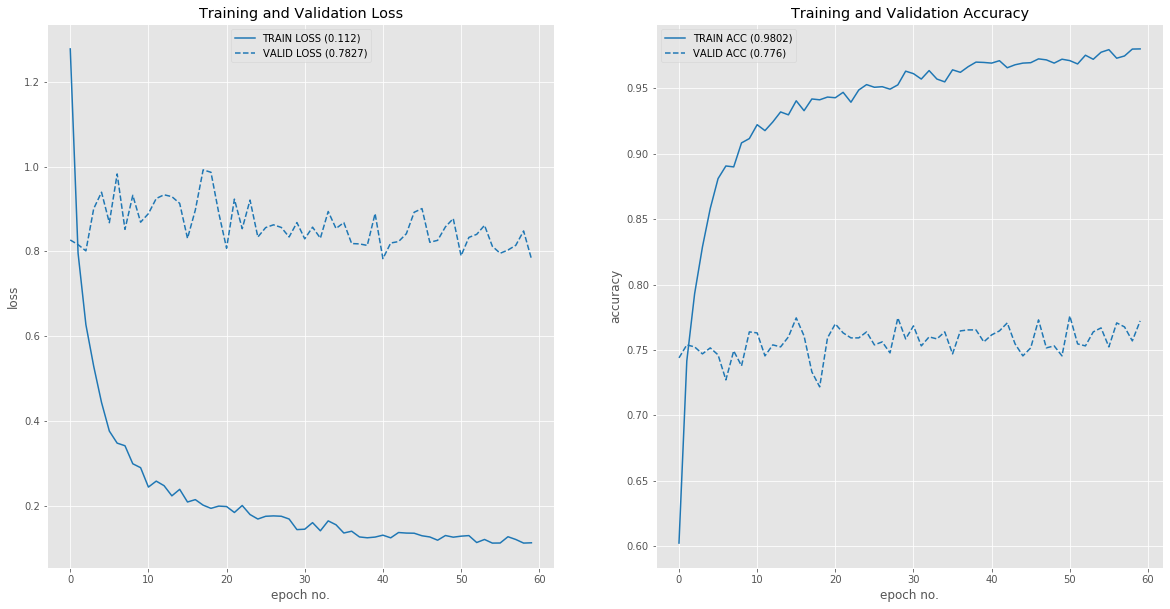

In [ ]:
plot_loss_accuracy(train_loss=[train_loss],
                   val_loss=[val_loss],
                   train_acc=[train_acc],
                   val_acc=[val_acc],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

In [ ]:
m = pretrained_resnext50()

m = load_model(m)

train_config = TrainingConfiguration()

data = val_data


mean=(0.5773, 0.4627, 0.3468)
std=(0.2387, 0.2470, 0.2473)

In [ ]:
cls, target = get_prediction(m, data, mean, std)

Getting predictions for batch  1 ...
Getting predictions for batch  2 ...
Getting predictions for batch  3 ...
Getting predictions for batch  4 ...
Getting predictions for batch  5 ...
Getting predictions for batch  6 ...
Getting predictions for batch  7 ...
Getting predictions for batch  8 ...
Getting predictions for batch  9 ...
Getting predictions for batch  10 ...
Getting predictions for batch  11 ...
Getting predictions for batch  12 ...
Getting predictions for batch  13 ...
Getting predictions for batch  14 ...
Getting predictions for batch  15 ...
Getting predictions for batch  16 ...
Getting predictions for batch  17 ...
Getting predictions for batch  18 ...
Getting predictions for batch  19 ...
Getting predictions for batch  20 ...
Getting predictions for batch  21 ...
Getting predictions for the last batch...


In [ ]:
#Accuracy and confusion matrix
accuracy, cn_matrix = accuracy_and_confusion_matrix(target, cls, id_to_class)

print("Accuracy: ", accuracy)
print("Confusion Matrix:\n")
print(cn_matrix)

Accuracy:  0.77217125382263
Confusion Matrix:

[[ 89   7   0   1   1   6   7   1   1   1   3   2   2]
 [  7 166   0   2   0   0   3   1   1   5   1   0   2]
 [  2   2  98   2   0   1   1   5   0   0   0   1   0]
 [  1   3   2  59   2   0   4   3   2   8   3   1  10]
 [  2   0   0   0  16   0   2   0   0  20   0   0   2]
 [  2   1   1   0   0 105   1   0   0   0   0   1   1]
 [  5   1   0   1   0   3  68   1   0   1   1   0   0]
 [  5   4   2   7   0   1   3  69   0   1   1   1   3]
 [  2   1   0   2   0   0   0   1  27   3   1   3   0]
 [  1   3   0   6  12   1   5   0   0 125   0   0   8]
 [  2   4   0   4   0   0   0   0   0   0  56   0   0]
 [  1   5   2   2   0   0   0   1   2   1   4  48  18]
 [  2   1   1   4   0   0   2   1   0   1   0  10  84]]


## <font style="color:green">8. TensorBoard Dev Scalars Log Link [5 Points]</font>

Share your tensorboard scalars logs link in this section. You can also share (not mandatory) your GitHub link if you have pushed this project in GitHub.

For example, [Find Project2 logs here](https://tensorboard.dev/experiment/kMJ4YU0wSNG0IkjrluQ5Dg/#scalars).

The link to tensorboard logs: https://tensorboard.dev/experiment/6DgRn8JGSnauPlHv8Uo14w/

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

Share your Kaggle profile link here with us so that we can give points for the competition score.

In [ ]:
dataset_test_df = pd.read_csv("test.csv", delimiter=' *, *', engine='python')

In [ ]:
test_data = []

for index, row in dataset_test_df.iterrows():
    test_data.append("images/images/"+str(row['id'])+".jpg")

print(len(test_data))

1638


In [ ]:
def get_prediction_for_test_data(model, data, mean, std):

    batch_size = 60

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2



    # transformed data
    test_dataset_trans = image_common_transforms()


    data_len = len(data)
    total_batches = data_len//batch_size
    rem_batch = data_len % batch_size

    classes = []

    index = 0
    # We prefer to do the predictions in batches and combine them later
    for j in range(total_batches):

        inputs = []
        print("Getting predictions for batch ",j+1,"...")
        for i in range(batch_size):
            img_path = data[index]
            img = Image.open(img_path)
            img = test_dataset_trans(img)

            inputs.append(img)
            index+= 1

        inputs = torch.stack(inputs)



        cls, prob = prediction(model, device, batch_input=inputs)
        classes.extend([item for item in cls])


    # Calculate predictions for the last remaining batch
    inputs = []
    print("Getting predictions for the last batch...")
    for i in range(rem_batch):
        img_path = data[index]
        img = Image.open(img_path)
        img = test_dataset_trans(img)

        inputs.append(img)
        index+= 1

    inputs = torch.stack(inputs)

    cls, prob = prediction(model, device, batch_input=inputs)
    classes.extend([item for item in cls])

    return np.array(classes), index

In [ ]:
test_classes, idx_count = get_prediction_for_test_data(m, test_data, mean, std)

Getting predictions for batch  1 ...
Getting predictions for batch  2 ...
Getting predictions for batch  3 ...
Getting predictions for batch  4 ...
Getting predictions for batch  5 ...
Getting predictions for batch  6 ...
Getting predictions for batch  7 ...
Getting predictions for batch  8 ...
Getting predictions for batch  9 ...
Getting predictions for batch  10 ...
Getting predictions for batch  11 ...
Getting predictions for batch  12 ...
Getting predictions for batch  13 ...
Getting predictions for batch  14 ...
Getting predictions for batch  15 ...
Getting predictions for batch  16 ...
Getting predictions for batch  17 ...
Getting predictions for batch  18 ...
Getting predictions for batch  19 ...
Getting predictions for batch  20 ...
Getting predictions for batch  21 ...
Getting predictions for batch  22 ...
Getting predictions for batch  23 ...
Getting predictions for batch  24 ...
Getting predictions for batch  25 ...
Getting predictions for batch  26 ...
Getting predictions f

In [ ]:
classes = [id_to_class[k] for k in test_classes]
ids = list(dataset_test_df['id'])

In [ ]:
test_dict = {'id':ids,'class':classes}
df_test_sample = pd.DataFrame.from_dict(test_dict)
df_test_sample.to_csv('submission_resnext.csv', index=False)

Kaggle details:

User name: kunaldawn7

User ID 3739739

Display Name: Kunal